# Correlating transporter abundances to environmental data

## Overview

Here normalized transporter abundances are compared to the environmental data.

In [8]:
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns, numpy as np
from scipy.stats import spearmanr
from statsmodels.stats import multitest
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from datetime import date
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
plt.style.use('ggplot')

## Functionality

In [9]:
def get_representatives(df):
    '''Finds representative families for each transporter based on highest mean'''
    df_mean = df.groupby(["fam","transporter"]).sum().mean(axis=1).reset_index()
    df_mean.sort_values(0,ascending=False,inplace=True)
    df_mean.index = list(range(0,len(df_mean)))
    reps = {}
    for i in df_mean.index:
        fam = df_mean.loc[i,"fam"]
        t = df_mean.loc[i,"transporter"]
        if t in reps.keys():
            continue
        reps[t] = fam
    return reps

In [10]:
def add_timepoints(df):
    timepoints = [date(2000+int(s[0:2]),int(s[2:4]),int(s[4:])).toordinal() for s in df.index]
    df = df.assign(Day=pd.Series(timepoints, index=df.index))
    dayrange = range(min(df.Day),max(df.Day)+1)
    _df = pd.DataFrame()
    for day in dayrange:
        if day in list(df.Day):
            continue
        else:
            _data = {'Temperature': np.nan,'Salinity': np.nan,'Chla': np.nan,'Nitrate': np.nan,'Phosphate': np.nan,
             'Silicate': np.nan,'Ammonium': np.nan,'DOC': np.nan,'TotalN': np.nan, 'Day': day}
            _df = pd.concat([pd.DataFrame(_data, index=[0]),_df])
    return pd.concat([df,_df.loc[:,df.columns]]).sort_values("Day")

In [11]:
def standardize(df):
    ts_stand = (df - df.mean()) / df.std()
    return ts_stand

In [12]:
def annotate_clustermap(ax, pvals, dec=1, minval=0.5):
    rows = ax.data.iloc[ax.dendrogram_row.reordered_ind,ax.dendrogram_col.reordered_ind].index
    cols = ax.data.iloc[ax.dendrogram_row.reordered_ind,ax.dendrogram_col.reordered_ind].columns
    # Extract plotted data from ax
    data_norm = ax.data2d
    # Extract original data
    a = ax.data
    if dec == 0:
        a = a.astype(int)
    else:
        a = np.round(a,dec)
    row_labels = [x.get_text() for x in ax.ax_heatmap.yaxis.get_ticklabels()]
    #row_labels.reverse()
    col_labels = [x.get_text() for x in ax.ax_heatmap.xaxis.get_ticklabels()]
    # Iterate each row item
    for row in range(len(a.index)):
        row_label = row_labels[row]
        for col in range(len(a.columns)):
            col_label = col_labels[col]
            pval = pvals.loc[row_label, col_label]
            zval = data_norm.loc[row_label,col_label]
            val = a.loc[row_label,col_label]
            if abs(zval) >= 0.5: 
                textcol = "white"
            else:
                textcol = "black"
            if val<=minval: continue
            add = ""
            if pval < 0.05:
                add = "*"
            ax.ax_heatmap.text(col+0.5,row+0.5,"{}{}".format(val,add),fontdict={'size':6,'color':textcol, 'horizontalalignment': 'center', 'verticalalignment': 'center'})
    return row_labels, col_labels

In [13]:
def fdr_correct(df):
    values = []
    for item in df.values:
        values+=list(item)
    all_corrected_values = multitest.fdrcorrection(values)[1]
    df_fdr = df.copy(deep=True)
    fdr_values = []
    i = 0
    for values in df.values:
        l = []
        for val in values:
            l.append(all_corrected_values[i])
            i+=1
        fdr_values.append(l)
    for i, t in enumerate(df_fdr.index):
        df_fdr.loc[t,:] = fdr_values[i]
    return df_fdr

In [16]:
cats = ["Anions","Cations","Nitrate","Metal","Urea","Phosphate","Phosphonate","AA peptide + (NH4+)","Nucleoside","Carbohydrate"]
cat_cols = sns.color_palette("Paired", 6) + sns.color_palette("Dark2",5)[1:]
cat_lut = dict(zip(map(str,cats),cat_cols))
cat_lut["Other"] = "black"
cat_lut["Rare nutr"] = "grey"

In [17]:
meta = pd.read_csv("data/LMO.time.series.metadata.csv", header=0, sep="\t", index_col=0)
meta.rename(index = lambda x: str(x)[2:],inplace=True)
metavars = ["Temperature","Salinity","Chla","Nitrate","Phosphate","Silicate","Ammonium","DOC","TotalN"]

## Metagenome

In [18]:
# Read normalized abundances of select transporters
mg_trans = pd.read_csv("results/mg/select_trans.tpm.tsv", header=0, index_col=0, sep="\t")
mg_trans_genes = pd.read_csv("results/mg/select_trans_genes.tpm.tsv", header=0, index_col=0, sep="\t")

In [19]:
# Make metadata conform
meta_mg = meta.loc[mg_trans.columns[4:],metavars]

In [20]:
# Add empty timepoints
plot_data = add_timepoints(meta_mg)
plot_data["sample"] = plot_data.index
plot_data = pd.melt(plot_data,id_vars=["sample","Day"])

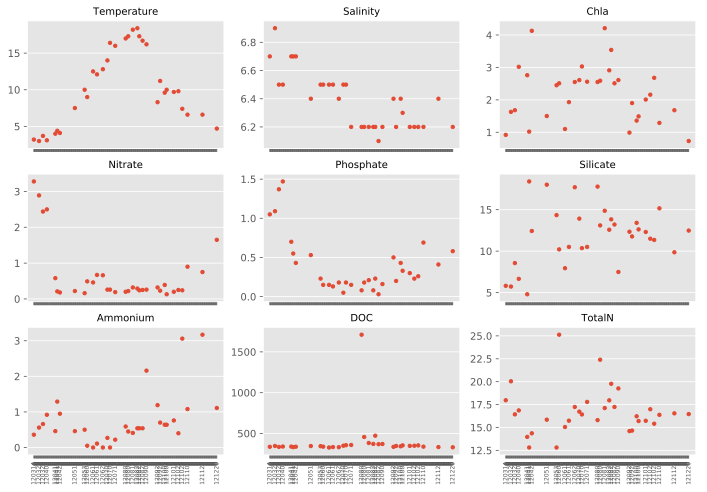

In [21]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(12,8), sharex=True, sharey=False)
all_axes = list(axes[0])+list(axes[1])+list(axes[2])
# Set up ticks
xticks = []
xticklabels = []
for i, day in enumerate(range(min(plot_data.Day),max(plot_data.Day)+1)):
    if day in list(plot_data.Day):
        xticks.append(i)
        xticklabels.append(plot_data.loc[plot_data.Day==day,"sample"].unique()[0])
# Plot subplots
for i, variable in enumerate(plot_data.variable.unique()):
    ax = sns.pointplot(data=plot_data.loc[plot_data.variable==variable],x="Day",y="value",
                       scale=0.5, ax=all_axes[i])
    ax.set_xlim(-10,len(range(min(plot_data.Day),max(plot_data.Day)+1))+10)
    ax.set_xticks(xticks);
    ax.set_xticklabels(xticklabels, rotation=90, fontsize=6);
    ax.set_title(variable, fontsize=10)
    ax.set_ylabel("")
    ax.set_xlabel("")

In [22]:
meta_mg.loc[meta_mg.DOC>400,"DOC"] = np.nan

In [23]:
meta_mg_stand = standardize(meta_mg)

In [24]:
mg_stand = standardize(mg_trans.groupby(level=0).sum())

In [25]:
# Get representative TIGRFAMs for use with y-axis
trans_reps = get_representatives(mg_trans_genes)

### Correlate

In [26]:
mg_cordf = pd.merge(mg_stand.T,meta_mg_stand,left_index=True,right_index=True)
mg_cor,mg_p = pd.DataFrame(spearmanr(mg_cordf)[0],columns=mg_cordf.columns,index=mg_cordf.columns),pd.DataFrame(spearmanr(mg_cordf)[1],columns=mg_cordf.columns,index=mg_cordf.columns)
mg_cor.drop(metavars,inplace=True)
mg_p.drop(metavars,inplace=True)
mg_cor.drop(mg_stand.index,inplace=True,axis=1, errors="ignore")
mg_p.drop(mg_stand.index,inplace=True,axis=1, errors="ignore")

In [27]:
# Get corrected p-values
mg_p_fdr = fdr_correct(mg_p)

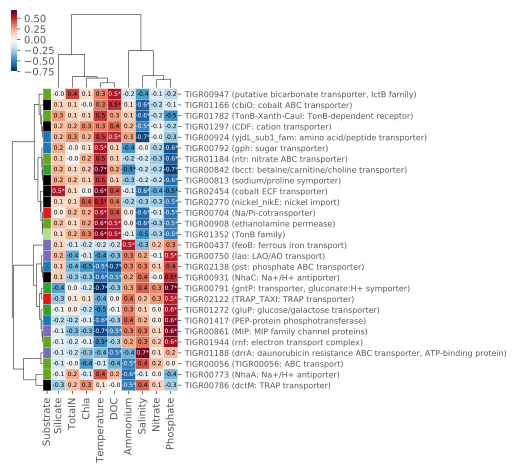

In [28]:
# Get significant transporters
mg_cor_sig = set(mg_p_fdr.loc[mg_p_fdr.min(axis=1)<0.05].index).intersection(set(mg_cor.loc[np.abs(mg_cor).groupby(level=0).max().max(axis=1)>=0.5].index))

# Assign row colors
row_cols = pd.Series([mg_trans.loc[t,"substrate_category"] for t in mg_cor_sig],index=mg_cor_sig).map(cat_lut)
row_cols.name="Substrate"

mg_ax = sns.clustermap(mg_cor.loc[mg_cor_sig],figsize=(3,7),linewidths=0.2,method="complete",metric="correlation", 
                      row_colors=row_cols, cmap="RdBu_r")
annotate_clustermap(ax=mg_ax,pvals=mg_p_fdr.loc[mg_cor_sig], minval=-10, dec=1)

# Change transporter labels to TIGRFAM
ticklocs = []
ticklabels = []
for i,item in enumerate(mg_cor.loc[mg_cor_sig].index):
    ticklocs.append(i+0.5)
    fam = trans_reps[item]
    name = mg_trans_genes.loc[mg_trans_genes.fam==fam,"name"].unique()[0]
    ticklabels.append("{} ({})".format(fam,name))
mg_ax.ax_heatmap.yaxis.set_ticks(ticklocs)
mg_ax.ax_heatmap.yaxis.set_ticklabels(ticklabels,fontsize=8);

plt.setp(mg_ax.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);
plt.savefig("results/Figure11A.svg", bbox_inches="tight")

## Metatranscriptome

In [29]:
mt_trans = pd.read_csv("results/mt/select_trans.tpm.tsv", header=0, index_col=0, sep="\t")
mt_trans_genes = pd.read_csv("results/mt/select_trans_genes.tpm.tsv", header=0, index_col=0, sep="\t")

In [30]:
meta_mt = meta.loc[mt_trans.columns[4:],metavars]

In [31]:
# Add empty timepoints
plot_data = add_timepoints(meta_mt)
plot_data["sample"] = plot_data.index
plot_data = pd.melt(plot_data,id_vars=["sample","Day"])

In [32]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(12,8), sharex=True, sharey=False)
all_axes = list(axes[0])+list(axes[1])+list(axes[2])
# Set up ticks
xticks = []
xticklabels = []
for i, day in enumerate(range(min(plot_data.Day),max(plot_data.Day)+1)):
    if day in list(plot_data.Day):
        xticks.append(i)
        xticklabels.append(plot_data.loc[plot_data.Day==day,"sample"].unique()[0])
# Plot subplots
for i, variable in enumerate(plot_data.variable.unique()):
    ax = sns.pointplot(data=plot_data.loc[plot_data.variable==variable],x="Day",y="value",
                       scale=0.5, ax=all_axes[i])
    ax.set_xlim(-10,len(range(min(plot_data.Day),max(plot_data.Day)+1))+10)
    ax.set_xticks(xticks);
    ax.set_xticklabels(xticklabels, rotation=90, fontsize=6);
    ax.set_title(variable, fontsize=10)
    ax.set_ylabel("")
    ax.set_xlabel("")

In [33]:
meta_mt_stand = standardize(meta_mt)

In [34]:
mt_stand = standardize(mt_trans.groupby(level=0).sum())

### Correlate

In [35]:
mt_cordf = pd.merge(mt_stand.T,meta_mt_stand,left_index=True,right_index=True)
mt_cor,mt_p = pd.DataFrame(spearmanr(mt_cordf)[0],columns=mt_cordf.columns,index=mt_cordf.columns),pd.DataFrame(spearmanr(mt_cordf)[1],columns=mt_cordf.columns,index=mt_cordf.columns)
mt_cor.drop(metavars,inplace=True)
mt_p.drop(metavars,inplace=True)
mt_cor.drop(mt_stand.index,inplace=True,axis=1, errors="ignore")
mt_p.drop(mt_stand.index,inplace=True,axis=1, errors="ignore")

In [36]:
# Get corrected p-values
mt_p_fdr = fdr_correct(mt_p)

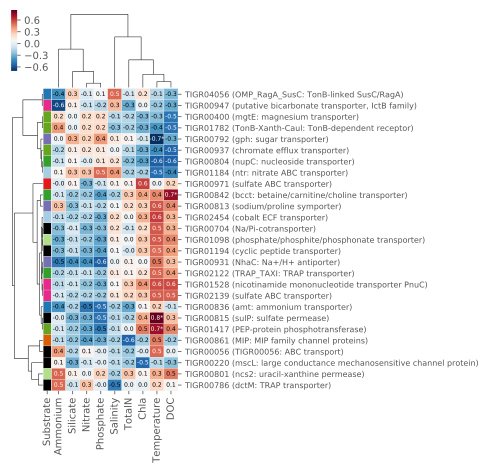

In [37]:
# Get significant transporters
# Because there are much fewer transporters found to be significant here, we plot all transporters 
# that have a abs(correlation) of at least 0.5 to one of the environmental variables and indicate signficant correlations
# with '*'
mt_cor_sig = set(mt_cor.loc[(mt_cor.min(axis=1)<=-0.5)|(mt_cor.max(axis=1)>=0.5)].index)
# Assign row colors
row_cols = pd.Series([mt_trans.loc[t,"substrate_category"] for t in mt_cor_sig],index=mt_cor_sig).map(cat_lut)
row_cols.name="Substrate"

mt_ax = sns.clustermap(mt_cor.loc[mt_cor_sig],figsize=(3,7),linewidths=0.2,method="complete",metric="correlation", 
                      row_colors=row_cols, cmap="RdBu_r")
annotate_clustermap(ax=mt_ax,pvals=mt_p_fdr.loc[mt_cor_sig], minval=-10,dec=1)
#mt_ax.ax_heatmap.yaxis.set_ticklabels([item.get_text()+" ("+mt_trans.loc[item.get_text(),"name"]+")" for item in mt_ax.ax_heatmap.yaxis.get_ticklabels()]);

# Change transporter labels to TIGRFAM
ticklocs = []
ticklabels = []
for i,item in enumerate(mt_cor.loc[mt_cor_sig].index):
    ticklocs.append(i+0.5)
    fam = trans_reps[item]
    name = mg_trans_genes.loc[mg_trans_genes.fam==fam,"name"].unique()[0]
    ticklabels.append("{} ({})".format(fam,name))
mt_ax.ax_heatmap.yaxis.set_ticks(ticklocs)
mt_ax.ax_heatmap.yaxis.set_ticklabels(ticklabels,fontsize=8);

plt.setp(mt_ax.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);
plt.savefig("results/Figure11B.svg", bbox_inches="tight")